## Modeling of bank failures by FDIC 

**Instructions:**
- You will be using Python 3.
- Avoid using for-loops and while-loops, unless you are explicitly told to do so.
- Do not modify the (# GRADED FUNCTION [function name]) comment in some cells. Your work would not be graded if you change this. Each cell containing that comment should only contain one function.
- After coding your function, run the cell right below it to check if your result is correct.
- The token generated by Coursera (COURSERA_TOKEN) expires every <b>30 minutes</b>. It is advisable to always work with the most recent generated token so as to avoid any submission related errors. If you receive such error messages, rerun the cells containing your code and the GRADED FUNCTION in the same order. 


## About iPython Notebooks ##

iPython Notebooks are interactive coding environments embedded in a webpage. You will be using iPython notebooks in this class. You only need to write code between the ### START CODE HERE ### and ### END CODE HERE ### comments. After writing your code, you can run the cell by either pressing "SHIFT"+"ENTER" or by clicking on "Run Cell" (denoted by a play symbol) in the upper bar of the notebook. 

We will often specify "(≈ X lines of code)" in the comments to tell you about how much code you need to write. It is just a rough estimate, so don't feel bad if your code is longer or shorter.

In [1]:
import pandas as pd
import numpy as np
import time

import os
import functools
import math
import random
import sys, getopt
import sklearn

sys.path.append("..")
import grading

try:
    import matplotlib.pyplot as plt
    %matplotlib inline
except:
    pass
print('scikit-learn version:', sklearn.__version__)

scikit-learn version: 0.18.2


In [2]:
### ONLY FOR GRADING. DO NOT EDIT ###
submissions=dict()
assignment_key="7VcH6P8REeeRWA42vRAjYg" 
all_parts=["o5YYT", "2cHUA", "Mxrav", "JFNf3", "ivHQa"]
### ONLY FOR GRADING. DO NOT EDIT ###

In [3]:
# token expires every 30 min
COURSERA_TOKEN = "ewcP487PBuaZpsoV" # the key provided to the Student under his/her email on submission page
COURSERA_EMAIL = "aadypillai@gmail.com" # the email

In [4]:
# common cell - share this across notebooks
state_cols = ['log_TA','NI_to_TA', 'Equity_to_TA', 'NPL_to_TL', 'REO_to_TA', 
              'ALLL_to_TL', 'core_deposits_to_TA', 'brokered_deposits_to_TA', 
              'liquid_assets_to_TA', 'loss_provision_to_TL', 'NIM', 'assets_growth']

all_MEVs = np.array(['term_spread',
                    'stock_mkt_growth',
                    'real_gdp_growth',
                    'unemployment_rate_change',
                    'treasury_yield_3m',
                    'bbb_spread',
                    'bbb_spread_change'])

MEV_cols = all_MEVs.tolist()

next_state_cols = ['log_TA_plus_1Q','NI_to_TA_plus_1Q', 'Equity_to_TA_plus_1Q', 'NPL_to_TL_plus_1Q', 'REO_to_TA_plus_1Q', 
                   'ALLL_to_TL_plus_1Q', 'core_deposits_to_TA_plus_1Q', 'brokered_deposits_to_TA_plus_1Q', 
                   'liquid_assets_to_TA_plus_1Q', 'loss_provision_to_TL_plus_1Q', 
                   'ROA_plus_1Q', 
                   'NIM_plus_1Q', 
                   'assets_growth_plus_1Q', 
                   'FDIC_assessment_base_plus_1Q_n']

In [5]:
df_train = pd.read_hdf('../readonly/df_train_FDIC_defaults_1Y.h5', key='df')
df_test = pd.read_hdf('../readonly/df_test_FDIC_defaults_1Y.h5', key='df')
df_data = pd.read_hdf('../readonly/data_adj_FDIC_small.h5', key='df')
df_closure_learn = pd.read_hdf('../readonly/df_FDIC_learn.h5',key='df')
print(df_closure_learn.index.names)

Opening ../readonly/df_train_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/df_test_FDIC_defaults_1Y.h5 in read-only mode
Opening ../readonly/data_adj_FDIC_small.h5 in read-only mode
Opening ../readonly/df_FDIC_learn.h5 in read-only mode
['IDRSSD', 'date']


## Construct training and testing datasets for logistic regression

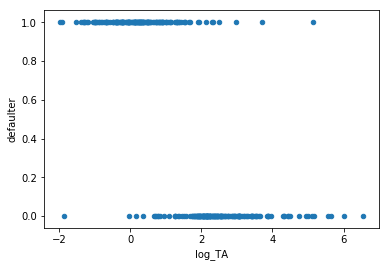

In [6]:
df_test.plot(x=state_cols[0], y='defaulter', kind='scatter')

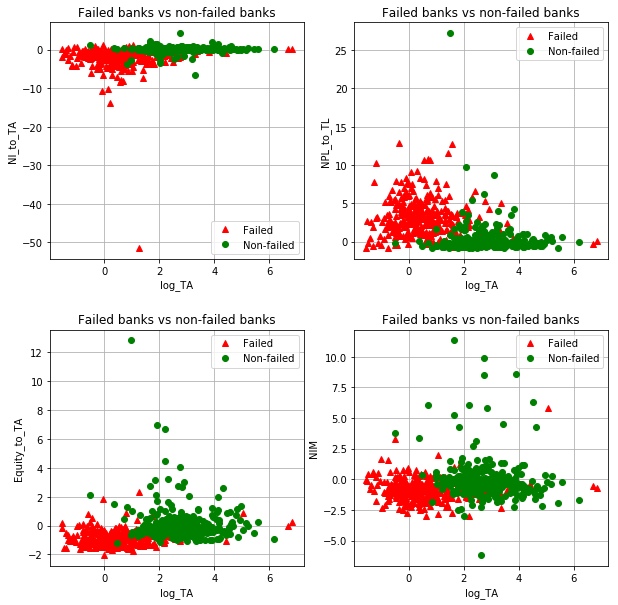

In [7]:
# Plot 4 scatter plots together

# log_TA / NI_to_TA
# log_TA / NPL_to_TL
# log_TA / Equity_to_TA
# log_TA /ROA

first_indx = [0, 0, 0, 0]
second_indx = [1, 3, 2, 10]

X_train = df_train[state_cols].values
y_train = df_train.defaulter.values # .reshape(-1,1)

num_plots = 4
if num_plots % 2 == 0:
    f, axs = plt.subplots(num_plots // 2, 2)
else:
    f, axs = plt.subplots(num_plots// 2 + 1, 2)
    
f.subplots_adjust(hspace=.3)

f.set_figheight(10.0)
f.set_figwidth(10.0)
    
for i in range(num_plots):
    if i % 2 == 0:
        first_idx = i // 2
        second_idx = 0
    else:
        first_idx = i // 2
        second_idx = 1
        
    axs[first_idx,second_idx].plot(X_train[y_train == 1.0, first_indx[i]], 
                                   X_train[y_train == 1.0, second_indx[i]], 'r^', label="Failed")
    axs[first_idx,second_idx].plot(X_train[y_train == 0.0, first_indx[i]], 
                                   X_train[y_train == 0.0, second_indx[i]], 'go',label="Non-failed") 
    
    axs[first_idx, second_idx].legend()
    axs[first_idx, second_idx].set_xlabel('%s' % state_cols[first_indx[i]])
    axs[first_idx, second_idx].set_ylabel('%s' % state_cols[second_indx[i]])
    axs[first_idx, second_idx].set_title('Failed banks vs non-failed banks')
    axs[first_idx, second_idx].grid(True)
    
if num_plots % 2 != 0:
    f.delaxes(axs[i // 2, 1])
    
# plt.savefig('Failed_vs_nonfailed_rr_plot.png')

In [8]:
df_train

,,Financial Institution Name,Institution Name,total_assets,defaulter,Failure / Assistance,log_TA,NI_to_TA,Equity_to_TA,NPL_to_TL,REO_to_TA,...,loss_provision_to_TL_plus_1Q,ROA_plus_1Q,NIM_plus_1Q,assets_growth_plus_1Q,default_within_1Y,Failure,max_total_assets,num_records,non_defaulter,const
IDRSSD,date,,,,,,,,,,,,,,,,,,,,,
904957,2008-03-31,COLORADO NATIONAL BANK,COLORADO NATIONAL BANK,1.421380e+05,1.0,FAILURE,-0.048734,-6.505183,-0.759562,0.880756,-0.162301,...,0.004823,-0.367905,-0.840312,-0.582232,1.0,1.0,1.421380e+05,31.0,0.0,1
202907,2011-06-30,"COMMUNITY BANK, NATIONAL ASSOCIATION",NaN,6.364903e+06,0.0,NaN,2.754852,0.143005,0.249275,-0.405931,-0.327268,...,-0.003057,0.205816,-0.140365,0.003962,0.0,NaN,8.494486e+06,60.0,1.0,1
652874,2012-12-31,"NEXBANK, SSB",NaN,7.847810e+05,0.0,NaN,1.211269,0.229021,-0.301031,-0.750449,-0.304600,...,-0.003506,0.470935,-0.799310,0.284815,0.0,NaN,2.698563e+06,60.0,1.0,1
9115,2003-03-31,COMMERCE BANK/SHORE NATIONAL ASSOCIATION,NaN,2.173481e+06,0.0,NaN,1.962490,0.253469,-0.922810,-0.752942,-0.374868,...,-0.002819,0.225454,-0.324276,1.091618,0.0,NaN,2.697759e+06,12.0,1.0,1
3344611,2012-06-30,"BANK OF AMERICA RHODE ISLAND, NATIONAL ASSOCIA...",NaN,1.940546e+07,1.0,NaN,3.576923,0.103615,0.088508,2.380231,-0.121243,...,0.001903,0.101099,-0.791229,-0.408817,0.0,NaN,3.921104e+07,31.0,0.0,1
2560526,2009-03-31,CENTENNIAL BANK,CENTENNIAL BANK,2.414400e+05,1.0,FAILURE,0.341981,-1.857315,-0.643992,4.583630,10.678175,...,-0.004326,-0.945865,-1.657427,-0.679579,1.0,1.0,2.414400e+05,35.0,0.0,1
12311,2002-12-31,"HUNTINGTON NATIONAL BANK, THE",NaN,2.739928e+07,0.0,NaN,3.831313,0.017434,-1.027312,-0.217300,-0.345599,...,-0.000178,0.196792,-0.589442,-0.048953,0.0,NaN,7.087978e+07,60.0,1.0,1
2714570,2009-06-30,SUN WEST BANK,SUN WEST BANK,4.081850e+05,1.0,FAILURE,0.729213,-4.605855,-0.730066,3.972000,0.165297,...,0.083667,-5.016063,-0.231379,-0.822222,1.0,1.0,4.558640e+05,36.0,0.0,1
1001152,2008-03-31,INTERNATIONAL BANK OF COMMERCE,NaN,9.359919e+06,0.0,NaN,3.039238,0.166162,-0.165557,-0.196155,-0.361847,...,-0.002651,0.187922,-0.467883,-0.214504,0.0,NaN,1.063811e+07,60.0,1.0,1


In [9]:
def calc_metrics(model, df_test, y_true, threshold=0.5):
    """
    Arguments:
    model - trained model such as DecisionTreeClassifier, etc.
    df_test - Data Frame of predictors
    y_true - True binary labels in range {0, 1} or {-1, 1}. If labels are not binary, pos_label should be explicitly given.
    """
    if model is None:
        return 0., 0., 0.
    
    # prediction 
    predicted_sm = model.predict(df_test, linear=False)
    predicted_binary = (predicted_sm > threshold).astype(int)

    # print(predicted_sm.shape, y_true.shape)
    fpr, tpr, _ = metrics.roc_curve(y_true, predicted_sm, pos_label=1)
    
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr) # Kolmogorov - Smirnov test

    # note that here teY[:,0] is the same as df_test.default_within_1Y
    accuracy_score = metrics.accuracy_score(y_true, predicted_binary)
    
    # equivalently, Area Under the ROC Curve could be computed as:
    # compute Area Under the Receiver Operating Characteristic Curve (ROC AUC) from prediction scores
    # auc_score = metrics.roc_auc_score(y_true, predicted_sm)

    try:
        plt.title('Logistic Regression ROC curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')

        # plt.savefig('ROC_curve_1.png')
        plt.show()
    except:
        pass

    return roc_auc, accuracy_score, ks

In [10]:
def make_test_train(df_train, df_test, choice=0, predict_within_1Y=False):
    """
    make the train and test datasets
    Arguments:
    choice - an integer 0 or -1. Controls selection of predictors. 
    Add tangible equity and assessment base as predictors

    predict_within_1Y - boolean  if True, predict defaults within one year
    Return:
        a tuple of:
        - training data set predictors, np.array
        - training data set : variable to predict, np.array
        - test data set : variable to predict, np.array
        - predictor variable names
    """
    
    if choice == -1: # only state cols
        predictors = state_cols
    elif choice == 0:  # original variables
        predictors = state_cols + MEV_cols 


    trX = df_train[predictors].values
    teX = df_test[predictors].values
    num_features = len(predictors)    
    num_classes = 2

    if predict_within_1Y == True:
        trY = df_train[['default_within_1Y','no_default_within_1Y']].values
        teY = df_test[['default_within_1Y','no_default_within_1Y']].values
    else:
        trY = df_train[['defaulter','non_defaulter']].values
        teY = df_test[['defaulter','non_defaulter']].values
    return trX, trY, teX, teY, predictors

In [11]:
# look at correlations
df_train[MEV_cols].corr()

,term_spread,stock_mkt_growth,real_gdp_growth,unemployment_rate_change,treasury_yield_3m,bbb_spread,bbb_spread_change
term_spread,1.000000,0.002993,-0.145941,0.299972,-0.633991,0.392349,-0.465767
stock_mkt_growth,0.002993,1.000000,-0.148941,0.461947,-0.081915,0.417379,-0.762702
real_gdp_growth,-0.145941,-0.148941,1.000000,-0.825802,0.041596,-0.820518,0.385007
unemployment_rate_change,0.299972,0.461947,-0.825802,1.000000,0.034355,0.881223,-0.657093
treasury_yield_3m,-0.633991,-0.081915,0.041596,0.034355,1.000000,-0.272072,0.290414
bbb_spread,0.392349,0.417379,-0.820518,0.881223,-0.272072,1.000000,-0.716249
bbb_spread_change,-0.465767,-0.762702,0.385007,-0.657093,0.290414,-0.716249,1.000000


## Logistic regression with statsmodels

### Part 1
Perform logistic regression using **cols_to_use** as predictors. Use df_train pandas DataFrame as training data set, and df_test pandas DataFrame as testing data set to perform prediction based on the already trained model. Utilize statsmodels package. The result of fitting logistic regression should be assigned to variable named **model**

In [12]:
print(" ")

In [13]:
import statsmodels.api as sm
from sklearn import metrics

cols_to_use = state_cols + MEV_cols  + ['const']
model = None
df_train['const'] = 1

### START CODE HERE ### (≈ 3 lines of code)
mdl = sm.Logit(df_train["defaulter"] , df_train[cols_to_use])
model = mdl.fit()
print(model.params.values)
print(model.summary())
### END CODE HERE ###

Optimization terminated successfully.
         Current function value: 0.159379
         Iterations 9
[ -1.4916624   -0.22788433  -1.67032574   0.4782253    0.1764743
   0.20534984  -0.45069902   0.10798384  -0.49249963  16.89059884
  -0.3215625   -0.03374337  -0.46399235   0.04385464  -0.03428739
   0.56454935  -0.43751197   0.20070553   0.35110798  -0.61387544]
                           Logit Regression Results                           
Dep. Variable:              defaulter   No. Observations:                  641
Model:                          Logit   Df Residuals:                      621
Method:                           MLE   Df Model:                           19
Date:                Fri, 31 Jan 2020   Pseudo R-squ.:                  0.7699
Time:                        03:43:10   Log-Likelihood:                -102.16
converged:                       True   LL-Null:                       -444.03
                                        LLR p-value:                1.006e-132
  

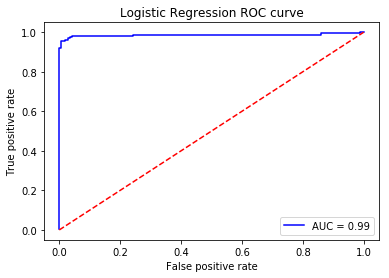

Accuracy score 0.969789
AUC score 0.986043
Kolmogorov-Smirnov statistic 0.950639


In [14]:
# prediction 
predicted_sm = np.array([])

### START CODE HERE ### (≈ 3 lines of code)
predicted_sm = model.predict(df_test[cols_to_use] , linear = False)
### END CODE HERE ###

threshold = 0.5
predicted_binary = (predicted_sm > threshold).astype(int)
auc_score, accuracy_score, ks = calc_metrics(model, df_test[cols_to_use], df_test.defaulter)

print('Accuracy score %f' % accuracy_score)
print('AUC score %f' % auc_score)
print('Kolmogorov-Smirnov statistic %f' % ks)

# note that here teY[:,0] is the same as df_test.default_within_1Y

In [15]:
### GRADED PART (DO NOT EDIT) ###
part_1=[accuracy_score, auc_score, ks]

try:
    part1 = " ".join(map(repr, part_1))
except TypeError:
    part1 = repr(part_1)    
    
submissions[all_parts[0]]=part1
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[0],all_parts,submissions)
[accuracy_score, auc_score, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.96978851963746227, 0.98604311289733282, 0.95063938618925836]

## Logistic Regression with sklearn

### Part 2 
In Part 2 you will use scikit-learn to perform logistic regression using the same training and test datasets.
Once the model is trained using trX, thisTrY, test it using teX, thisTeY and compute logistic regression score.

- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [16]:
print(" ")

In [17]:
from sklearn import neighbors, linear_model

trX, trY, teX, teY, predictors = make_test_train(df_train, df_test)
lr_score = 0.96
thisTrY = trY[:,0]
thisTeY = teY[:,0]

logistic = None # instantiate a model and reference it
result = None # result of fitting the model

### START CODE HERE ### (≈ 3 lines of code)
# .... define random_state argment in logistic regression class. Ininitialize it to 42
# such as this: random_state=42
# the variable name required for grading lr_score

from sklearn.linear_model import LogisticRegression
logistic = LogisticRegression(C = 1e20 , penalty = "l1" , tol = 0.000001, random_state=42, fit_intercept = True)
result = logistic.fit(trX , thisTrY)
lr_score = logistic.score(teX , thisTeY)

### END CODE HERE ###
print('LogisticRegression score: %f' % lr_score)

LogisticRegression score: 0.969789


In [18]:
### GRADED PART (DO NOT EDIT) ###
part2=str(lr_score)   
submissions[all_parts[1]]=part2
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:2],all_parts,submissions)
lr_score
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.96978851963746227

**Instructions:**
In this part you will again use scikit learn logistic regression but with different set of predictors. This will be a smaller set of predictor variables based on the analysis of P-values from the logistic regression. Use cols_to_use as predictors in df_train and df_test data sets. Use  **defaulter** column as something to predict.

Initialize reference to the logistic regression model **logistic** with an instance of appropriate class from  scikit learn module and let **result** be the result of fitting the model to the training data set.

Just as before initialize the model with the following parameters:
- Use **"l1"** penalty
- Set inverse of regularization strength to **1000.0**; must be a positive float. Like in support vector machines, smaller values specify stronger regularization.
- Set tolerance to **1e-6**

In [19]:
print(" ")

In [20]:
# Do Logistic Regression with a smaller number of predictor, based on analysis of P-values 
# for the logistic regression with a full set of variables

# a smaller set is based on the analysis of P-values for the logistic regression
cols_to_use = ['log_TA', 'NI_to_TA', 'Equity_to_TA', 'NPL_to_TL',
               'core_deposits_to_TA',
               'brokered_deposits_to_TA',
               'liquid_assets_to_TA'
              ,'term_spread', 'stock_mkt_growth'] 


lr_score = 0.
logistic = None
result = None
### START CODE HERE ### (≈ 3 lines of code)
# .... when initializing logistic regression class in 'sklearn', set random_state to 42 like this: random_state=42
# ... like this: random_state=42
# ... for grading, please store the logistic regression model into variable : logistic
trX = df_train[cols_to_use].values
teX = df_test[cols_to_use].values
thisTrY = (df_train.defaulter.values)
thisTeY = (df_test.defaulter.values)
logistic = LogisticRegression(C = 1e3 , penalty = "l1" , tol = 0.000001, random_state=42, fit_intercept = True)
result = logistic.fit(trX , thisTrY)
lr_score = logistic.score(teX , thisTeY)
print(lr_score)
### END CODE HERE ###

# combine results of the Logistic Regression to a small dataframe df_coeffs_LR
df_coeffs_LR = pd.DataFrame({0: np.array([0.] * (len(cols_to_use) + 1), dtype=np.float32)})
if logistic is not None:
    model_params = np.hstack((logistic.coef_[0], logistic.intercept_))
    df_coeffs_LR = pd.DataFrame(data=model_params, index=cols_to_use + ['const'])
    df_coeffs_LR
print(df_coeffs_LR)

0.963746223565
                                0
log_TA                  -1.473230
NI_to_TA                -0.797122
Equity_to_TA            -1.884348
NPL_to_TL                0.338078
core_deposits_to_TA     -0.502668
brokered_deposits_to_TA  0.023561
liquid_assets_to_TA     -0.513417
term_spread              0.011348
stock_mkt_growth         0.026440
const                   -0.093846


In [21]:
### GRADED PART (DO NOT EDIT) ###
part_3=list(df_coeffs_LR.values.squeeze())
try:
    part3 = " ".join(map(repr, part_3))
except TypeError:
    part3 = repr(part_3)    
submissions[all_parts[2]]=part3
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:3],all_parts,submissions)
df_coeffs_LR.values.squeeze()
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


array([-1.47322995, -0.79712207, -1.88434794,  0.33807849, -0.50266831,
        0.02356076, -0.5134171 ,  0.01134757,  0.02644036, -0.09384567])

## Logistic Regression with Tensorflow

In [22]:
# Setup inputs and expeced outputs for Logistic Regression using Tensorflow
cols = state_cols + MEV_cols
# inputs to Logistic Regression (via Tensorflow)
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# add constant columns to both
X_trainTf = np.hstack((np.ones((X_trainTf.shape[0], 1)), X_trainTf))
X_testTf = np.hstack((np.ones((X_testTf.shape[0], 1)), X_testTf))

# exepectd outputs:
y_trainTf = df_train.defaulter.astype('int').values.reshape(-1,1)
y_testTf = df_test.defaulter.astype('int').values.reshape(-1,1)

In [23]:
print('Unique values to predict:', np.unique(y_trainTf))
print('Number of samples to train on:', y_trainTf.shape[0])
print('Number of samples to test on:', y_testTf.shape[0])

Unique values to predict: [0 1]
Number of samples to train on: 641
Number of samples to test on: 331


In [24]:
print("")

In [25]:
# to make this notebook's output stable across runs
def reset_graph(seed=42):
    tf.reset_default_graph()
    tf.set_random_seed(seed)
    np.random.seed(seed)

In [26]:
def random_batch(X_train, y_train, batch_size):
    np.random.seed(42)
    rnd_indices = np.random.randint(0, len(X_train), batch_size)
    X_batch = X_train[rnd_indices]
    y_batch = y_train[rnd_indices]
    return X_batch, y_batch

In [27]:
#X_batch, Y_batch = random_batch(X_trainTf , y_trainTf , batch_size)
#Y_batch.shape

### Build Logistic Regression TF model

**instructions**

in tensorflow create: 
 - placeholder for inputs called 'X' 
 - placeholder for inputs called 'y'
 - variable for model parameters called 'theta', initialized with theta_init

loss function: use log loss
optimizer: use Gradient Descent optimizer

In [28]:
import tensorflow as tf

#learning_rate = 0.01
#batch_size = 50
#n_epochs = 1000

# define the model

reset_graph()
n_inputs = X_trainTf.shape[1]
learning_rate = 0.01
theta_init = tf.random_uniform([n_inputs, 1], -1.0, 1.0, seed=42)

# build Logistic Regression model using Tensorflow

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
Y = tf.placeholder(tf.float32, shape=(None, 1), name="y")
theta = tf.Variable(theta_init, name="theta")
#b = tf.Variable(tf.random_normal(shape=[1, 1]))

### START CODE HERE ### (≈ 6-7 lines of code)
### ....
### .... for grading please store probabilities in y_proba
z = tf.matmul(X , theta)
y_proba = tf.sigmoid(z)  
loss = tf.losses.log_loss(Y, y_proba, epsilon=1e-07)
Optimizer = tf.train.GradientDescentOptimizer(learning_rate=learning_rate).minimize(loss)
                # = 1 / (1 + tf.exp(-logits))
# uses epsilon = 1e-7 by default to regularize the log function

### END CODE HERE ###

init = tf.global_variables_initializer()


### Train Logistic Regression TF model

**Instructions**
- Use random_batch() function to grab batches from X_trainTf and y_trainTf.
- Once the model is trained evaluate it based on X_testTf and y_testTf. 
- The **y_proba_val** should be assigned the result of the evaluation on test dataset.

In [31]:
n_epochs = 1001
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))

y_proba_val = np.array([], dtype=np.float32)

with tf.Session() as sess:
    sess.run(init)    
    ### START CODE HERE ### (≈ 6-7 lines of code)
    ## ....
    for epoch in range(n_epochs):
        for batch_index in range(n_batches):
            X_trainTf_batch , y_trainTf_batch = random_batch(X_trainTf , y_trainTf , batch_size)
            _,l,_=sess.run([y_proba,loss,Optimizer], feed_dict = {X: X_trainTf_batch , Y: y_trainTf_batch})
        print(" loss: " + str(l))
    y_proba_val = sess.run(y_proba, feed_dict={X: X_testTf})

    ### END CODE HERE ###

 loss: 0.82635
 loss: 0.792687
 loss: 0.764197
 loss: 0.739725
 loss: 0.718416
 loss: 0.69963
 loss: 0.682882
 loss: 0.667803
 loss: 0.654106
 loss: 0.641568
 loss: 0.630013
 loss: 0.6193
 loss: 0.609318
 loss: 0.599975
 loss: 0.591196
 loss: 0.58292
 loss: 0.575097
 loss: 0.567684
 loss: 0.560647
 loss: 0.553956
 loss: 0.547586
 loss: 0.541515
 loss: 0.535726
 loss: 0.530201
 loss: 0.524928
 loss: 0.519894
 loss: 0.515087
 loss: 0.510499
 loss: 0.50612
 loss: 0.501941
 loss: 0.497955
 loss: 0.494153
 loss: 0.490528
 loss: 0.487073
 loss: 0.483781
 loss: 0.480644
 loss: 0.477657
 loss: 0.474813
 loss: 0.472104
 loss: 0.469526
 loss: 0.46707
 loss: 0.464732
 loss: 0.462505
 loss: 0.460383
 loss: 0.458362
 loss: 0.216617
 loss: 0.131639
 loss: 0.128843
 loss: 0.126905
 loss: 0.125206
 loss: 0.123648
 loss: 0.122198
 loss: 0.120838
 loss: 0.119556
 loss: 0.118342
 loss: 0.117189
 loss: 0.116092
 loss: 0.115044
 loss: 0.114042
 loss: 0.113083
 loss: 0.112162
 loss: 0.111277
 loss: 0.110425

 loss: 0.0476263
 loss: 0.0475783
 loss: 0.0475304
 loss: 0.0474827
 loss: 0.047435
 loss: 0.0473875
 loss: 0.0473401
 loss: 0.0472928
 loss: 0.0472456
 loss: 0.0471985
 loss: 0.0471515
 loss: 0.0471046
 loss: 0.0470578
 loss: 0.0470112
 loss: 0.0469646
 loss: 0.0469181
 loss: 0.0468718
 loss: 0.0468255
 loss: 0.0467794
 loss: 0.0467334
 loss: 0.0466874
 loss: 0.0466416
 loss: 0.0465959
 loss: 0.0465502
 loss: 0.0465047
 loss: 0.0464593
 loss: 0.046414
 loss: 0.0463688
 loss: 0.0463236
 loss: 0.0462786
 loss: 0.0462337
 loss: 0.0461889
 loss: 0.0461442
 loss: 0.0460995
 loss: 0.046055
 loss: 0.0460106
 loss: 0.0459663
 loss: 0.045922
 loss: 0.0458779
 loss: 0.0458339
 loss: 0.0457899
 loss: 0.0457461
 loss: 0.0457023
 loss: 0.0456587
 loss: 0.0456151
 loss: 0.0455717
 loss: 0.0455283
 loss: 0.045485
 loss: 0.0454418
 loss: 0.0453987
 loss: 0.0453557
 loss: 0.0453128
 loss: 0.04527
 loss: 0.0452273
 loss: 0.0451847
 loss: 0.0451422
 loss: 0.0450997
 loss: 0.0450574
 loss: 0.0450151
 los

 loss: 0.0322829
 loss: 0.0322626
 loss: 0.0322422
 loss: 0.0322219
 loss: 0.0322017
 loss: 0.0321814
 loss: 0.0321612
 loss: 0.032141
 loss: 0.0321208
 loss: 0.0321006
 loss: 0.0320805


In [32]:
# predictions
threshold = 0.5
y_pred = (y_proba_val >= threshold)
print(np.sum(y_pred))

149


In [33]:
np.hstack([y_pred<=0.5 , y_testTf==0])

array([[False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [ True,  True],
       [False, False],
       [ True, False],
       [ True,  True],
       [False, False],
       [False, False],
       [False, False],
       [ True,  True],
       [False,  True],
       [False, False],
       [ True,  True],
       [False, False],
       [Fal

In [34]:
y_pred.squeeze()

array([ True, False, False,  True,  True,  True, False,  True, False,
        True, False,  True, False, False, False,  True, False, False,
        True, False,  True, False, False, False, False, False, False,
       False, False, False, False, False,  True, False, False,  True,
        True,  True, False,  True,  True, False,  True,  True,  True,
       False, False, False, False,  True,  True,  True, False,  True,
       False,  True, False, False, False,  True,  True,  True, False,
        True,  True,  True, False,  True, False,  True, False,  True,
       False, False, False, False,  True, False,  True,  True,  True,
        True, False,  True, False, False,  True, False, False,  True,
       False, False,  True, False, False,  True, False,  True,  True,
        True,  True,  True, False,  True, False,  True, False,  True,
        True, False,  True, False,  True, False,  True,  True, False,
        True, False, False,  True,  True, False,  True, False, False,
       False, False,

precision:  0.979865771812
recall:  0.906832298137
AUC score =  0.982243332115
roc_auc =  0.982243332115
KS_test =  0.927438801608


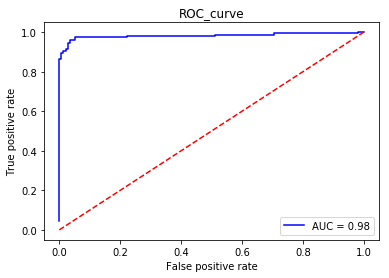

In [35]:
# evaluate precision, recall, and AUC

auc_score = 0.
ks = 0.
roc_auc = 0.
recall = 0.
precision = 0.

from sklearn.metrics import precision_score, recall_score
if y_proba_val.shape == y_testTf.shape:
    precision = precision_score(y_testTf, y_pred)
    recall = recall_score(y_testTf, y_pred)
    auc_score = metrics.roc_auc_score(y_testTf, y_proba_val)
    fpr, tpr, threshold = metrics.roc_curve(y_testTf, y_proba_val, pos_label=1)
    roc_auc = metrics.auc(fpr, tpr)
    ks = np.max(tpr - fpr)

    print('precision: ', precision)
    print('recall: ', recall)
    print('AUC score = ', auc_score)
    print('roc_auc = ', roc_auc)
    print('KS_test = ', ks)

    try:
        plt.title('ROC_curve')
        plt.plot(fpr, tpr, 'b', label='AUC = %0.2f' % roc_auc)
        plt.legend(loc='lower right')
        plt.plot([0,1], [0,1], 'r--')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.savefig('ROC_curve_TF.png')
        plt.show()
    except:
        pass

In [36]:
### GRADED PART (DO NOT EDIT) ###
part_4=list([precision, recall, roc_auc, ks])
try:
    part4 = " ".join(map(repr, part_4))
except TypeError:
    part4 = repr(part_4)
submissions[all_parts[3]]=part4
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:4],all_parts,submissions)
[precision, recall, roc_auc, ks]
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


[0.97986577181208057,
 0.90683229813664601,
 0.98224333211545489,
 0.92743880160759962]

## Neural Network with Tensorflow

In [37]:
cols = state_cols + MEV_cols
n_inputs = len(cols)

# inputs 
X_trainTf = df_train[cols].values
X_testTf = df_test[cols].values

# outputs 
y_trainTf = df_train['defaulter'].astype('int').values.reshape(-1,)
y_testTf = df_test['defaulter'].astype('int').values.reshape(-1,)

In [38]:
import numpy as np
def neuron_layer(X, n_neurons, name, activation=None):
    with tf.name_scope(name):
        tf.set_random_seed(42)
        n_inputs = int(X.get_shape()[1])
        stddev = 2 / np.sqrt(n_inputs)
        init = tf.truncated_normal((n_inputs, n_neurons), stddev=stddev)
        W = tf.Variable(init, name="kernel")
        b = tf.Variable(tf.zeros([n_neurons]), name="bias")
        Z = tf.matmul(X, W) + b
        if activation is not None:
            return activation(Z)
        else:
            return Z

### Construct Neural Network

**Instructions**
Implement Neural Network with two hidden layers. The number of nodes in the first and the second hidden layers is **n_hidden1** and **n_hidden2** correspondingly.
Use neuron_layer() function to construct neural network layers.

- Use ReLU activation function for hidden layers
- The output layer has **n_outputs** and does not have an activation function
- Use sparse softmax cross-entropy with logits as a loss function

In [39]:
n_hidden1 = 20
n_hidden2 = 10
n_outputs = 2 # binary classification (defaulted, not defaulted bank)

reset_graph()

X = tf.placeholder(tf.float32, shape=(None, n_inputs), name="X")
y = tf.placeholder(tf.int32, shape=(None), name="y")

### 
### ...

hidden_layer_1 = neuron_layer(X , n_hidden1 , "layer_1", activation = tf.nn.relu)
hidden_layer_2 = neuron_layer(hidden_layer_1 , n_hidden2, "layer_2" , activation = tf.nn.relu)
output_layer = neuron_layer(hidden_layer_2 , n_outputs , "output_layer")
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits = output_layer , labels = y))
optimizer = tf.train.GradientDescentOptimizer(learning_rate = 0.05).minimize(loss)
accuracy = tf.reduce_mean(tf.cast(tf.equal(tf.argmax(y, axis=-1), tf.argmax(output_layer, axis=-1)), tf.float32))

### 

init = tf.global_variables_initializer()

### Train Neural Network

**Instructions**
Train neural network passing batches of inputs of size **batch_size**, which predicts bank defaults / non-defaults. Once the network is trained, evaluate accuracy using **X_testTf**, **y_testTf**


In [40]:
learning_rate = 0.05
n_epochs = 400
batch_size = 50
num_rec = X_trainTf.shape[0]
n_batches = int(np.ceil(num_rec / batch_size))
acc_test = 0. #  assign the result of accuracy testing to this variable

### 
# ... variable required for testing acc_test
with tf.Session() as sess:
    sess.run(init)
    for epoch in range(n_epochs):
        avg_cost = 0
        total_batch = int(X_trainTf.shape[0]/batch_size)
        for batch in range(batch_size):
            X_trainTf_batch,y_trainTf_batch = random_batch(X_trainTf,y_trainTf,batch_size)
            _ , l = sess.run([optimizer , loss], feed_dict = {X: X_trainTf_batch , y: y_trainTf_batch})
            #avg_cost = avg_cost + (l / total_batch)
        #print("Epoch:", (epoch+1), "cost =", "{:.5f}".format(avg_cost))
    print("\nTraining complete!")
    y_pre_val = sess.run(output_layer,feed_dict = {X: X_testTf})
acc_test = precision_score(y_testTf,np.argmax(y_pre_val,axis = 1))
print(acc_test)


### 


Training complete!
0.929032258065


In [41]:
### GRADED PART (DO NOT EDIT) ###
part5=str(acc_test)
submissions[all_parts[4]]=part5
grading.submit(COURSERA_EMAIL, COURSERA_TOKEN, assignment_key, all_parts[:5],all_parts,submissions)
acc_test
### GRADED PART (DO NOT EDIT) ###

Submission successful, please check on the coursera grader page for the status


0.92903225806451617